In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy import wcs
from astropy.io import fits
from PIL import Image
from astropy import units as u


from astropy.coordinates import SkyCoord

import utils

In [64]:
df = pd.read_csv('/Users/user/repos/zoobot-3d/data/gz3d_and_gz_desi_master_catalog.csv')
galaxy = df.iloc[32]
galaxy

ra_subject                                                          165.29715
dec_subject                                                         12.474752
mangaid                                                              1-304336
iauname                                                   J110111.31+122829.1
ifudesignsize                                                           127.0
manga_tileid                                                           6800.0
nsa_id                                                                 321982
explorer_link               http://skyserver.sdss.org/dr13/en/tools/chart/...
gz_total_classifications                                                   34
gz_bar_votes                                                               14
gz_spiral_votes                                                            13
sample                                                               original
best_match                                                      

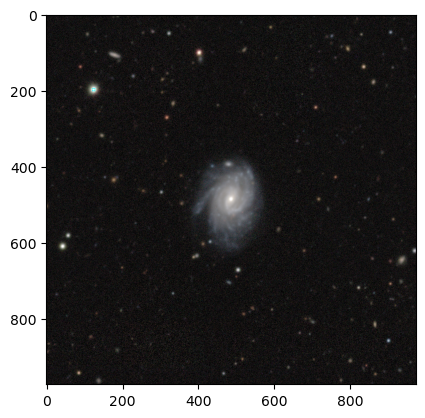

In [65]:
desi_im = fits.open(galaxy['local_desi_fits_loc'])[0].data
# desi_im = desi_im.transpose(1, 2, 0)  # channels last

desi_im = np.array(utils.fits_to_png(desi_im))

# .transpose(Image.FLIP_TOP_BOTTOM).resize((525, 525))
plt.imshow(desi_im)

In [66]:
def get_wcs_for_image(center_ra: float, center_dec: float, im: np.array, survey='desi'):

    w = wcs.WCS(naxis=2)

    # example astropy use
    # https://docs.astropy.org/en/stable/wcs/example_create_imaging.html
    # explanation from
    # http://tdc-www.harvard.edu/wcstools/wcstools.wcs.html

    # CRPIX1 and CRPIX2 are the pixel coordinates of the reference point to which the projection and the rotation refer.
    # (technically, these would be the brick center coordinates I think, but hopefully it won't matter to approx as galaxy center) 
    w.wcs.crpix = [im.shape[0]/2, im.shape[1]/2]

    # CDELT1 and CDELT2 have been used to indicate the plate scale in degrees per pixel
    if survey == 'desi':
        arcsec_per_pixel = 0.262
    elif survey == 'gz3d':
        arcsec_per_pixel = 0.099
    else:
        raise ValueError(survey)
    w.wcs.cdelt = np.array([arcsec_per_pixel/3600, arcsec_per_pixel/3600])

    # CRVAL1 and CRVAL2 give the center coordinate as right ascension and declination or longitude and latitude in decimal degrees. 
    w.wcs.crval = [center_ra, center_dec]
    # CTYPE1 and CTYPE2 indicate the coordinate type and projection. 
    # The first four characters are RA-- and DEC-, GLON and GLAT, or ELON and ELAT, for equatorial, galactic, and ecliptic coordinates, respectively.
    # The second four characters contain a four-character code for the projection. The presence of the CTYPE1 keyword is used to select for this WCS subset. 
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

    # https://fits.gsfc.nasa.gov/registry/tpvwcs/tpv.html
    # The TPV World Coordinate System is a non-standard convention following the rules of the WCS standard. 
    # It builds on the standard TAN projection by adding a general polynomial distortion correction
    # ...
    # Apply the distortion transformation using the coefficients in the PV keywords
    # (I don't need distortions here)
    # w.wcs.set_pv([(2, 1, 45.0)])

    return w

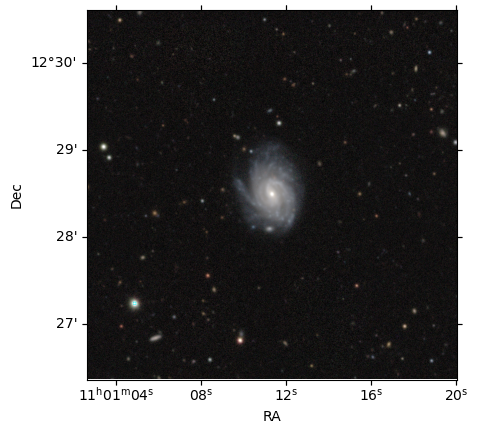

In [67]:
wcs_desi = get_wcs_for_image(center_ra=galaxy['ra'], center_dec=galaxy['dec'], survey='desi', im=desi_im)

# https://docs.astropy.org/en/stable/wcs/wcstools.html#matplotlib-plots-with-correct-wcs-projection
fig = plt.figure()
ax = plt.subplot(projection=wcs_desi)
ax.imshow(desi_im, origin='lower')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

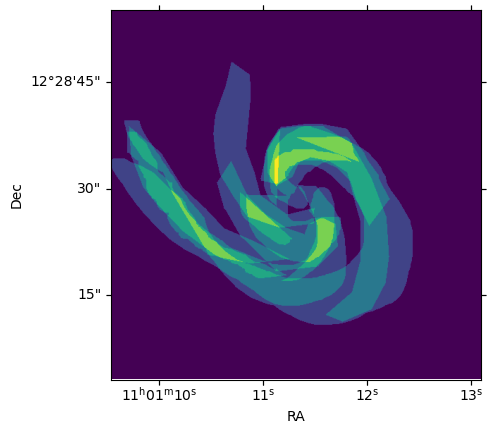

In [71]:
# repeat for gz3d

seg_im = fits.open(galaxy['local_gz3d_fits_loc'])[3].data
# plt.imshow(seg_im)
# flip, probably this is in the original fits header
seg_im = seg_im[-1::-1, :]

wcs_gz3d = get_wcs_for_image(center_ra=galaxy['ra'], center_dec=galaxy['dec'], survey='gz3d', im=seg_im)

# https://docs.astropy.org/en/stable/wcs/wcstools.html#matplotlib-plots-with-correct-wcs-projection
fig = plt.figure()
ax = plt.subplot(projection=wcs_gz3d)
plt.imshow(seg_im, origin='lower', cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')

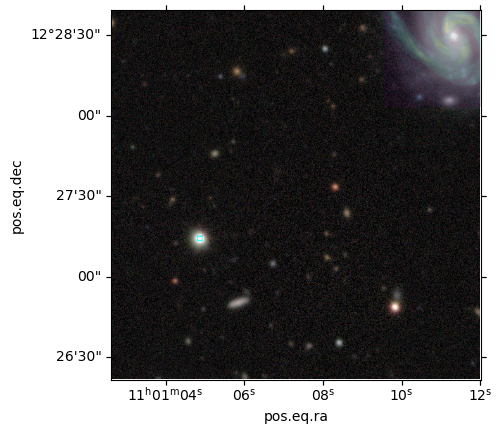

In [81]:
# combine
# https://docs.astropy.org/en/stable/visualization/wcsaxes/overlays.html
fig = plt.figure()
ax = plt.subplot(projection=wcs_desi)
ax.imshow(desi_im, transform=ax.get_transform(wcs_desi))
ax.imshow(seg_im, transform=ax.get_transform(wcs_gz3d), alpha=.15)

# ax.set_xlim(pixel_coords_x)
# ax.set_ylim(pixel_coords_y)

In [90]:

# https://docs.sunpy.org/en/stable/generated/gallery/plotting/xy_lims.html
# ax.set_xlim([galaxy['ra'] - 0.001, galaxy['ra'] + 0.001])
xlims_world = galaxy['ra'] * u.degree + np.array([-52/2, 52/2]) * u.arcsec
ylims_world = galaxy['dec'] * u.degree + np.array([-52/2, 52/2]) * u.arcsec
xlims_world, ylims_world

(<Quantity [165.28991241, 165.30435685] deg>,
 <Quantity [12.4675273 , 12.48197174] deg>)

In [91]:

world_coords = SkyCoord(ra=xlims_world, dec=ylims_world)
pixel_coords_x, pixel_coords_y = wcs_desi.world_to_pixel(world_coords)
pixel_coords_x

array([388.60350453, 582.39109137])

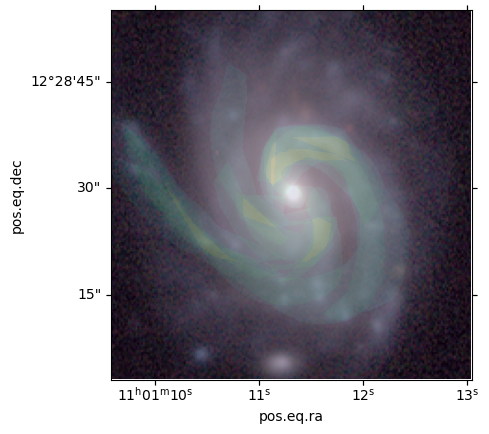

In [92]:

ax.set_xlim(pixel_coords_x)
ax.set_ylim(pixel_coords_y)
fig